In [1]:
%pylab inline
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

folder="../../../../../sebas/data/air_qual_aemet/"
stations = os.listdir(folder)
stations = pd.Series(stations).apply(lambda e: e.split(".csv")[0]).values

In [3]:
fields=['AEMET.BLH', 'AEMET.SP', 'AEMET.T2M', 'AEMET.TP', 'AEMET.U10',
       'AEMET.V10', 'AEMET.WS', 'AEMET.WD', 'MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

fields=['MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

#fields=['SPA.NO2', 'SPA.O3']

fields=['SPA.NO2']

In [4]:
from tqdm.notebook import tqdm

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
seq_length=168

In [7]:
stations=["28079004"]

  0%|          | 0/1 [00:00<?, ?it/s]

28079004: SPA.NO2


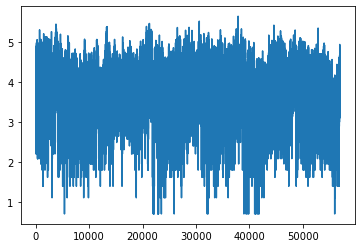

In [8]:
X_train=[]
y_train=[]
for station in tqdm(stations):
    # Reading input file
    df = pd.read_csv(f"{folder}/{station}.csv",sep=";")
    # Limiting Date
    df = df[df["DATE"]<"2020-01-01"]
    for field in fields:
        print(f"{station}: {field}")
        
        tdf = df[["DATE",field]].copy()

        #Stop is there are null values
        if (tdf[field].isnull().sum()>0):
          break

        # Log transform
        tdf[field]=np.log1p(tdf[field])

        plt.plot(tdf[field])
        plt.show()
        #STL Decomp
        #stl = seasonal_decompose(tdf[field], model="additive",period=24)

        #tdf[field]=tdf[field]-stl.seasonal
        #tdf["trend"]=stl.trend
        tdf["trend"]=0


        horizon=13

        tdf["trend_norm"]=tdf["trend"].shift(horizon)

        # We remove the trend and keep past values
        tdf[field]=tdf[field]-tdf["trend_norm"]
        for h in np.arange(0,horizon+seq_length+1):
            if h>horizon:
                temp = pd.DataFrame()
                temp[f"value - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
                tdf=pd.concat([tdf,temp],axis=1)

        tdf=tdf.dropna()

        cols = tdf.columns[tdf.columns.str.contains(f"value -")]
        X = tdf[cols].copy()
        y = tdf[[field]].copy()
        y.columns=["values"]

        TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

        X_train.append(X[X.index<=TRAIN_SPLIT].copy())
        y_train.append(y[X.index<=TRAIN_SPLIT].copy())
        
X_train=pd.concat(X_train)
y_train=pd.concat(y_train)

In [9]:
X.shape

(56796, 168)

In [10]:
X_train.shape

(39277, 168)

In [11]:
station="28079004"
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")

# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

field="SPA.NO2"

tdf = df[["DATE",field]].copy()
tdf[field]=np.log1p(tdf[field])

#from statsmodels.tsa.seasonal import seasonal_decompose
#stl = seasonal_decompose(tdf[field], model="additive",period=24)
#tdf[field]=tdf[field]-stl.seasonal
#tdf["trend"]=stl.trend
tdf["seasonal"]=0
tdf["trend"]=0

horizon=13

tdf["trend_norm"]=tdf["trend"].shift(horizon)

# We remove the trend and keep past values
for h in np.arange(0,horizon+seq_length+1):
    if h>horizon:
            temp = pd.DataFrame()
            temp[f"{field} - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
            tdf=pd.concat([tdf,temp],axis=1)
tdf=tdf.dropna()

cols = tdf.columns[tdf.columns.str.contains(f"{field} -")]
X = tdf[cols].copy()
y = tdf[[field]].copy()
v_recover = tdf[["trend_norm","seasonal"]]

TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

X_test=X[X.index>TRAIN_SPLIT].copy()
y_test = y[X.index>TRAIN_SPLIT].copy()
v_recover_test = v_recover[X.index>TRAIN_SPLIT].copy()

In [12]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset, random_split

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test= torch.FloatTensor(y_test.values)

In [13]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


In [14]:
import pytorch_lightning as pl

class TCN(pl.LightningModule):
    def __init__(self,n_channels=128,k_size=3,regressor_size=200):
        super().__init__()
        
        self.n_channels, self.k_size, self.regressor_size = n_channels, k_size, regressor_size

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=self.n_channels, 
                      kernel_size=self.k_size, 
                      padding=(int(self.k_size/2))),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(self.n_channels*int(seq_length/2)),
            nn.Linear(self.n_channels*int(seq_length/2),self.regressor_size),
            nn.ReLU(),
            nn.LayerNorm(self.regressor_size),
            nn.Linear(self.regressor_size,1)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,self.n_channels*x.shape[2])
        return self.regressor(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        # We would have to modify this for better aggregation
        # https://forums.pytorchlightning.ai/t/understanding-logging-and-validation-step-validation-epoch-end/291/2
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)
        

    def configure_optimizers(self):
        optimizer = COCOBBackprop(self.parameters())
        return optimizer


In [15]:
# setup data
X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
train_loader = DataLoader(train, batch_size=4098, shuffle=True,num_workers=8)
valid_loader = DataLoader(valid, batch_size=256)

In [16]:
from pytorch_lightning.callbacks import EarlyStopping

trainer = pl.Trainer(max_epochs=100,
                     accelerator="gpu",
                     max_time="00:00:00:30",
                     callbacks=[EarlyStopping("val_loss",
                                              verbose=True, 
                                              patience=3,
                                              mode="min")])
tcn=TCN(n_channels=16,k_size=5,regressor_size=200)
trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 96    
1 | regressor | Sequential | 272 K 
-----------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.090     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 99.345


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.767 >= min_delta = 0.0. New best score: 90.578


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.753 >= min_delta = 0.0. New best score: 83.826


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.572 >= min_delta = 0.0. New best score: 81.254


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.494 >= min_delta = 0.0. New best score: 79.760


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.072 >= min_delta = 0.0. New best score: 74.688


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.941 >= min_delta = 0.0. New best score: 72.747


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 72.747. Signaling Trainer to stop.


In [17]:
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
test = TensorDataset(X_test_gf, y_test)
test_loader = DataLoader(test, batch_size=256, num_workers=8)
trainer.test(tcn,test_loader)[0]["test_loss"]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            81.3760986328125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


81.3760986328125

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 10it [00:00, ?it/s]

 Val Loss: 0.5647438014525256


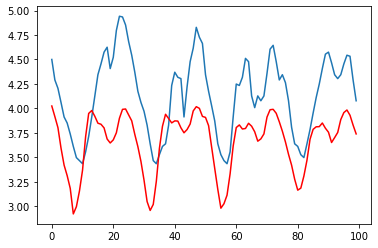

In [18]:
from sklearn.metrics import mean_squared_error

allp=np.array([])
for p in trainer.predict(tcn,test_loader):
    allp = np.concatenate([allp,p.reshape(-1)])
print(f' Val Loss: {np.sqrt(mean_squared_error(allp,y_test))}')
    
plt.plot(y_test.cpu()[-100:])
plt.plot(allp[-100:],c="red")
plt.show()

In [19]:
"""trainer.checkpoint_callback.best_model_path
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
model = tcn.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
model.freeze()
model = model.eval()"""

'trainer.checkpoint_callback.best_model_path\nX_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))\nmodel = tcn.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)\nmodel.freeze()\nmodel = model.eval()'

### Parameters:
- Number of channels
- Kernel Size
- Maxpool size
- Batch Size
- Epochs
- Regressor:
    - Size
    - Number of hidden layers

In [20]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter
from smac.facade.smac_bb_facade import SMAC4BB
from smac.scenario.scenario import Scenario

In [21]:
def train_model(config):
    
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_channels= config["n_channels"]
    ksize = config["ksize"]
    regressor_size= config["regressor_size"]

    # Setup data
    X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
    train = TensorDataset(X_train_gf, y_train)
    train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=8)
    valid_loader = DataLoader(valid, batch_size=256)

    from pytorch_lightning.callbacks import EarlyStopping

    trainer = pl.Trainer(max_epochs=epochs,
                         accelerator="gpu",
                         max_time="00:00:01:00",
                         callbacks=[EarlyStopping("val_loss",
                                                  verbose=True, 
                                                  patience=3,
                                                  mode="min")])

    tcn=TCN(n_channels=n_channels,k_size=ksize,regressor_size=regressor_size)
    trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    test = TensorDataset(X_test_gf, y_test)
    test_loader = DataLoader(test, batch_size=256, num_workers=8)

    return trainer.test(tcn,test_loader)[0]["test_loss"]

In [22]:
# Define your hyperparameters
configspace = ConfigurationSpace()
configspace.add_hyperparameter(UniformIntegerHyperparameter("batch_size", 30, 4000))
configspace.add_hyperparameter(UniformIntegerHyperparameter("epochs", 2, 20))
configspace.add_hyperparameter(UniformIntegerHyperparameter("n_channels", 8, 256))
configspace.add_hyperparameter(UniformIntegerHyperparameter("ksize", 3, 20))
configspace.add_hyperparameter(UniformIntegerHyperparameter("regressor_size", 50, 1000))

# Provide meta data for the optimization
scenario = Scenario({
    "run_obj": "quality",  
    "runcount-limit": 100,  
    "cs": configspace,
})

smac = SMAC4BB(scenario=scenario, tae_runner=train_model)
best_found_config = smac.optimize()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.4 K 
1 | regressor | Sequential | 2.4 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.438     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.906


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 20.471 >= min_delta = 0.0. New best score: 77.435


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.602 >= min_delta = 0.0. New best score: 74.833


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.896 >= min_delta = 0.0. New best score: 72.937


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.126 >= min_delta = 0.0. New best score: 69.811


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.026 >= min_delta = 0.0. New best score: 68.785


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 68.676


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 68.239
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            83.09480285644531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.3 K 
1 | regressor | Sequential | 15.8 M
-----------------------------------------
15.8 M    Trainable params
0         Non-trainable params
15.8 M    Total params
63.333    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 106.552


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.520 >= min_delta = 0.0. New best score: 105.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.066 >= min_delta = 0.0. New best score: 101.966


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.635 >= min_delta = 0.0. New best score: 87.330


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.015 >= min_delta = 0.0. New best score: 77.316


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.385 >= min_delta = 0.0. New best score: 75.930
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            85.1571273803711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 190   
1 | regressor | Sequential | 2.3 M 
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 107.880


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.557 >= min_delta = 0.0. New best score: 100.323


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 16.372 >= min_delta = 0.0. New best score: 83.951


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.376 >= min_delta = 0.0. New best score: 81.575


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 81.556


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.112 >= min_delta = 0.0. New best score: 80.444


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.553 >= min_delta = 0.0. New best score: 77.891


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.878 >= min_delta = 0.0. New best score: 77.013


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.227 >= min_delta = 0.0. New best score: 72.785


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.479 >= min_delta = 0.0. New best score: 71.306


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 71.306. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            77.6888198852539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.7 K 
1 | regressor | Sequential | 5.8 M 
-----------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.389    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.879


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.211 >= min_delta = 0.0. New best score: 88.668


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.887 >= min_delta = 0.0. New best score: 78.781


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.956 >= min_delta = 0.0. New best score: 75.825


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.822 >= min_delta = 0.0. New best score: 75.003


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.581 >= min_delta = 0.0. New best score: 74.421


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.234 >= min_delta = 0.0. New best score: 73.187


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.199 >= min_delta = 0.0. New best score: 71.988


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             81.259521484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.6 K 
1 | regressor | Sequential | 7.1 M 
-----------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.340    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.765


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.576 >= min_delta = 0.0. New best score: 76.189


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.329 >= min_delta = 0.0. New best score: 74.860


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 74.697


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.270 >= min_delta = 0.0. New best score: 74.427


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.891 >= min_delta = 0.0. New best score: 72.536
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.6 K 
1 | regressor | Sequential | 3.6 M 
-----------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.469    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            81.20618438720703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.829 >= min_delta = 0.0. New best score: 83.172


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.282 >= min_delta = 0.0. New best score: 79.889


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.149 >= min_delta = 0.0. New best score: 76.741


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 76.304


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.542 >= min_delta = 0.0. New best score: 73.762


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.968 >= min_delta = 0.0. New best score: 72.794


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.936 >= min_delta = 0.0. New best score: 71.858


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.872 >= min_delta = 0.0. New best score: 70.986


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.280 >= min_delta = 0.0. New best score: 70.705


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.862 >= min_delta = 0.0. New best score: 69.843


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 400   
1 | regressor | Sequential | 2.1 M 
-----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.519     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            83.35911560058594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 102.377


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.927 >= min_delta = 0.0. New best score: 91.450
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           102.70053100585938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.2 K 
1 | regressor | Sequential | 16.2 M
-----------------------------------------
16.2 M    Trainable params
0         Non-trainable params
16.2 M    Total params
64.733    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.254


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.608 >= min_delta = 0.0. New best score: 102.647


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.343 >= min_delta = 0.0. New best score: 101.304


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.210 >= min_delta = 0.0. New best score: 92.094


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.106 >= min_delta = 0.0. New best score: 84.988


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.349 >= min_delta = 0.0. New best score: 80.639


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 80.639. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            92.08134460449219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 688   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.860     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 83.358


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.419 >= min_delta = 0.0. New best score: 76.939


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.110 >= min_delta = 0.0. New best score: 73.829


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.215 >= min_delta = 0.0. New best score: 70.614


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.375 >= min_delta = 0.0. New best score: 69.239


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.478 >= min_delta = 0.0. New best score: 68.761


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.834 >= min_delta = 0.0. New best score: 67.927


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 885   
1 | regressor | Sequential | 4.9 M 
-----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.447    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.60673522949219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 82.817


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.005 >= min_delta = 0.0. New best score: 71.812


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.748 >= min_delta = 0.0. New best score: 70.064


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 69.949


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.817 >= min_delta = 0.0. New best score: 69.132


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.359 >= min_delta = 0.0. New best score: 68.774


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 68.774. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            84.7794418334961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 894   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.667     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 110.680


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.592 >= min_delta = 0.0. New best score: 105.087


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.570 >= min_delta = 0.0. New best score: 100.518


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.664    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           121.57162475585938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 101.038


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.345 >= min_delta = 0.0. New best score: 92.693


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.269 >= min_delta = 0.0. New best score: 80.424


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.493 >= min_delta = 0.0. New best score: 76.931


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.949 >= min_delta = 0.0. New best score: 74.982


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 74.921


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.635 >= min_delta = 0.0. New best score: 74.286


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.549 >= min_delta = 0.0. New best score: 73.737


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 73.683


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.893 >= min_delta = 0.0. New best score: 70.789
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.91316223144531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.8 K 
1 | regressor | Sequential | 12.5 M
-----------------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
50.136    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 114.129


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.300 >= min_delta = 0.0. New best score: 107.828


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 16.191 >= min_delta = 0.0. New best score: 91.638


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.485 >= min_delta = 0.0. New best score: 88.153


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.549 >= min_delta = 0.0. New best score: 78.604


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.982 >= min_delta = 0.0. New best score: 73.622
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.54698944091797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 900   
1 | regressor | Sequential | 11.0 M
-----------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.088    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.071


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.130 >= min_delta = 0.0. New best score: 92.941


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 19.650 >= min_delta = 0.0. New best score: 73.291


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.449 >= min_delta = 0.0. New best score: 67.843


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.333 >= min_delta = 0.0. New best score: 66.509


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.951 >= min_delta = 0.0. New best score: 65.559


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.422 >= min_delta = 0.0. New best score: 64.137


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 64.137. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.8246841430664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.6 K 
1 | regressor | Sequential | 3.9 M 
-----------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.677    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 104.891


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.476 >= min_delta = 0.0. New best score: 100.415


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 13.673 >= min_delta = 0.0. New best score: 86.743


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.069 >= min_delta = 0.0. New best score: 81.674


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.399 >= min_delta = 0.0. New best score: 79.275


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.649 >= min_delta = 0.0. New best score: 76.627


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 76.627. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.9 K 
1 | regressor | Sequential | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.778     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            89.05329895019531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 111.336


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.675 >= min_delta = 0.0. New best score: 107.661


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.477 >= min_delta = 0.0. New best score: 98.185


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.691 >= min_delta = 0.0. New best score: 92.494


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.602 >= min_delta = 0.0. New best score: 86.892


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.984 >= min_delta = 0.0. New best score: 84.908


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.572 >= min_delta = 0.0. New best score: 84.336


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.367 >= min_delta = 0.0. New best score: 82.969


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.970 >= min_delta = 0.0. New best score: 81.999


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.394 >= min_delta = 0.0. New best score: 80.606


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 80.441


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.099 >= min_delta = 0.0. New best score: 79.342
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 361   
1 | regressor | Sequential | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.441     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.6479263305664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.122


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.239 >= min_delta = 0.0. New best score: 97.883


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.487 >= min_delta = 0.0. New best score: 87.396
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            98.37258911132812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.7 K 
1 | regressor | Sequential | 9.0 M 
-----------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
36.073    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.741


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 24.180 >= min_delta = 0.0. New best score: 79.560


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.322 >= min_delta = 0.0. New best score: 76.238


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.240 >= min_delta = 0.0. New best score: 74.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.436 >= min_delta = 0.0. New best score: 72.563


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 72.563. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            83.88894653320312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.5 K 
1 | regressor | Sequential | 6.2 M 
-----------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.813    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 108.190


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.741 >= min_delta = 0.0. New best score: 105.449


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.351 >= min_delta = 0.0. New best score: 97.098


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.129 >= min_delta = 0.0. New best score: 84.969
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            94.0217514038086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 10.7 M
-----------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 108.104


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.781 >= min_delta = 0.0. New best score: 105.322


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.200 >= min_delta = 0.0. New best score: 90.123


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.374 >= min_delta = 0.0. New best score: 82.748


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.119 >= min_delta = 0.0. New best score: 79.630


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 79.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.265 >= min_delta = 0.0. New best score: 78.321


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.425 >= min_delta = 0.0. New best score: 76.896


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.445 >= min_delta = 0.0. New best score: 76.451


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.745 >= min_delta = 0.0. New best score: 75.706


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 75.269


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.477 >= min_delta = 0.0. New best score: 74.792


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 918   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.961     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            82.83827209472656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 105.677


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.570 >= min_delta = 0.0. New best score: 95.107


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.870 >= min_delta = 0.0. New best score: 82.237


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.239 >= min_delta = 0.0. New best score: 78.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.819 >= min_delta = 0.0. New best score: 78.180


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.414 >= min_delta = 0.0. New best score: 76.766


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.343 >= min_delta = 0.0. New best score: 76.424


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.299 >= min_delta = 0.0. New best score: 75.124
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 351   
1 | regressor | Sequential | 277 K 
-----------------------------------------
277 K     Trainable params
0         Non-trainable params
277 K     Total params
1.110     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            84.67440032958984
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 101.780


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 17.969 >= min_delta = 0.0. New best score: 83.811


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.035 >= min_delta = 0.0. New best score: 79.776


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.568 >= min_delta = 0.0. New best score: 78.208


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.925 >= min_delta = 0.0. New best score: 77.282


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.605 >= min_delta = 0.0. New best score: 76.677


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 76.474


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 76.233


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.059 >= min_delta = 0.0. New best score: 75.174


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 74.948
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 740   
1 | regressor | Sequential | 12.5 M
-----------------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
49.806    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            85.68854522705078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.598


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.984 >= min_delta = 0.0. New best score: 107.614


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.714 >= min_delta = 0.0. New best score: 101.900


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 20.688 >= min_delta = 0.0. New best score: 81.213


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.525 >= min_delta = 0.0. New best score: 74.687


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.581 >= min_delta = 0.0. New best score: 71.107


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.040 >= min_delta = 0.0. New best score: 70.067


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.4430923461914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.1 K 
1 | regressor | Sequential | 5.1 M 
-----------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.332    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 110.593


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.447 >= min_delta = 0.0. New best score: 109.146


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.853 >= min_delta = 0.0. New best score: 105.293


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.507 >= min_delta = 0.0. New best score: 89.786


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.865 >= min_delta = 0.0. New best score: 86.920


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.041 >= min_delta = 0.0. New best score: 80.879


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.658 >= min_delta = 0.0. New best score: 79.221


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.216 >= min_delta = 0.0. New best score: 78.005


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.418 >= min_delta = 0.0. New best score: 77.588


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 77.392


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.042 >= min_delta = 0.0. New best score: 76.350


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 76.350. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.2 K 
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.301    Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            93.94078063964844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.190


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.586 >= min_delta = 0.0. New best score: 65.604


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.410 >= min_delta = 0.0. New best score: 65.194
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.0119857788086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.5 K 
1 | regressor | Sequential | 9.8 M 
-----------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.291    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 74.496


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.226 >= min_delta = 0.0. New best score: 70.269


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.218 >= min_delta = 0.0. New best score: 67.051


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.603 >= min_delta = 0.0. New best score: 65.448
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            77.61774444580078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 688   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.918     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.401


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.668 >= min_delta = 0.0. New best score: 69.733


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.151 >= min_delta = 0.0. New best score: 67.581


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.477 >= min_delta = 0.0. New best score: 66.105


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.918 >= min_delta = 0.0. New best score: 64.187


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 64.114


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.323 >= min_delta = 0.0. New best score: 63.791


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.350 >= min_delta = 0.0. New best score: 62.441


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 62.178


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 62.157
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 704   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.002     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.90531921386719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.158


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.446 >= min_delta = 0.0. New best score: 67.712


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.266 >= min_delta = 0.0. New best score: 67.446


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.575 >= min_delta = 0.0. New best score: 65.871


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.583 >= min_delta = 0.0. New best score: 63.288


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.544 >= min_delta = 0.0. New best score: 61.744


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.389 >= min_delta = 0.0. New best score: 61.355


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.229 >= min_delta = 0.0. New best score: 60.126


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.314 >= min_delta = 0.0. New best score: 59.812


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 59.671
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 704   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.943     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.49372863769531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 77.210


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.752 >= min_delta = 0.0. New best score: 72.459


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.477 >= min_delta = 0.0. New best score: 69.982


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.739 >= min_delta = 0.0. New best score: 68.243


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.237 >= min_delta = 0.0. New best score: 66.006


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 66.006. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.48565673828125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 704   
1 | regressor | Sequential | 1.3 M 
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.062     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.355


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.160 >= min_delta = 0.0. New best score: 69.195


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.988 >= min_delta = 0.0. New best score: 68.207


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.146 >= min_delta = 0.0. New best score: 67.060


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.401 >= min_delta = 0.0. New best score: 65.660


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.862 >= min_delta = 0.0. New best score: 64.798


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.699 >= min_delta = 0.0. New best score: 64.099


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.252 >= min_delta = 0.0. New best score: 62.847


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.319 >= min_delta = 0.0. New best score: 62.529


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 62.489
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.35418701171875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.6 K 
1 | regressor | Sequential | 8.1 M 
-----------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.324    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.981


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.990 >= min_delta = 0.0. New best score: 102.990


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 17.632 >= min_delta = 0.0. New best score: 85.359


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.142 >= min_delta = 0.0. New best score: 78.216


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.074 >= min_delta = 0.0. New best score: 74.142


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.638 >= min_delta = 0.0. New best score: 72.504


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.442 >= min_delta = 0.0. New best score: 70.062


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 69.656
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.85298919677734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 2.3 M 
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 76.274


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.099 >= min_delta = 0.0. New best score: 74.176


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.194 >= min_delta = 0.0. New best score: 72.981


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 72.849


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.376 >= min_delta = 0.0. New best score: 71.473


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.331 >= min_delta = 0.0. New best score: 69.142


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.489 >= min_delta = 0.0. New best score: 66.653


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.914 >= min_delta = 0.0. New best score: 65.740


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.27999877929688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 696   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.975     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 72.431


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.520 >= min_delta = 0.0. New best score: 69.911


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.509 >= min_delta = 0.0. New best score: 66.402
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.415 >= min_delta = 0.0. New best score: 62.987
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 696   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.946     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.45899200439453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 78.743


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.899 >= min_delta = 0.0. New best score: 72.845


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.906 >= min_delta = 0.0. New best score: 70.938


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.721 >= min_delta = 0.0. New best score: 69.217


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.314 >= min_delta = 0.0. New best score: 67.903


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.896 >= min_delta = 0.0. New best score: 66.007


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.950 >= min_delta = 0.0. New best score: 64.057


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            83.68174743652344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 696   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.975     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 67.719


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.704 >= min_delta = 0.0. New best score: 65.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.060 >= min_delta = 0.0. New best score: 62.956


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.441 >= min_delta = 0.0. New best score: 62.515


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.383 >= min_delta = 0.0. New best score: 58.132


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 58.132. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.7030029296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 696   
1 | regressor | Sequential | 1.3 M 
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.033     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.307


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.511 >= min_delta = 0.0. New best score: 64.796


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.765 >= min_delta = 0.0. New best score: 63.031
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.247 >= min_delta = 0.0. New best score: 62.784
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.03579711914062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 2.3 M 
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.258     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 69.419


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.529 >= min_delta = 0.0. New best score: 66.890


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.82585144042969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 120   
1 | regressor | Sequential | 216 K 
-----------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.071


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.278 >= min_delta = 0.0. New best score: 65.793


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.468 >= min_delta = 0.0. New best score: 64.324


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.06770324707031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 552   
1 | regressor | Sequential | 991 K 
-----------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.969     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.451


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.498 >= min_delta = 0.0. New best score: 63.952
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.740 >= min_delta = 0.0. New best score: 63.212
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.57369995117188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.017     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.266


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.342 >= min_delta = 0.0. New best score: 71.924


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.924 >= min_delta = 0.0. New best score: 69.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.110 >= min_delta = 0.0. New best score: 67.890


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.138 >= min_delta = 0.0. New best score: 66.752


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 66.541


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.743 >= min_delta = 0.0. New best score: 64.798


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.528 >= min_delta = 0.0. New best score: 64.270


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 64.094
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 800   
1 | regressor | Sequential | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.752     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.40361785888672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 80.549


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.712 >= min_delta = 0.0. New best score: 76.836


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.449 >= min_delta = 0.0. New best score: 75.387


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.393 >= min_delta = 0.0. New best score: 71.994


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.433 >= min_delta = 0.0. New best score: 70.561


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.290 >= min_delta = 0.0. New best score: 70.271


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.186 >= min_delta = 0.0. New best score: 69.086
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.04953002929688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 1.6 M 
-----------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.406     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 80.872


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.706 >= min_delta = 0.0. New best score: 78.166


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.380 >= min_delta = 0.0. New best score: 74.787


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.464 >= min_delta = 0.0. New best score: 72.323


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.013 >= min_delta = 0.0. New best score: 71.310


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 71.282


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 71.135
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.19202423095703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.5 K 
1 | regressor | Sequential | 2.4 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 75.569


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.294 >= min_delta = 0.0. New best score: 70.275


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.527 >= min_delta = 0.0. New best score: 67.747


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.397 >= min_delta = 0.0. New best score: 66.351


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.454 >= min_delta = 0.0. New best score: 65.896


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.356 >= min_delta = 0.0. New best score: 65.540


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.841 >= min_delta = 0.0. New best score: 62.699


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.037 >= min_delta = 0.0. New best score: 61.662
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.84394073486328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 508   
1 | regressor | Sequential | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.259     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.184


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.779 >= min_delta = 0.0. New best score: 68.405


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.001 >= min_delta = 0.0. New best score: 60.403


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.817 >= min_delta = 0.0. New best score: 58.586


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.457 >= min_delta = 0.0. New best score: 58.129


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.84416961669922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.8 K 
1 | regressor | Sequential | 2.9 M 
-----------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.752    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.909


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.790 >= min_delta = 0.0. New best score: 68.118


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.768 >= min_delta = 0.0. New best score: 66.350


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.546 >= min_delta = 0.0. New best score: 63.804


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 63.728


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.596 >= min_delta = 0.0. New best score: 63.132


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.891 >= min_delta = 0.0. New best score: 62.241


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.361 >= min_delta = 0.0. New best score: 60.880


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.677 >= min_delta = 0.0. New best score: 60.203
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.64244842529297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 608   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.841     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.784


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.393 >= min_delta = 0.0. New best score: 66.391


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.337 >= min_delta = 0.0. New best score: 64.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.269 >= min_delta = 0.0. New best score: 62.785


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.482 >= min_delta = 0.0. New best score: 62.303


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.492 >= min_delta = 0.0. New best score: 61.811


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.651 >= min_delta = 0.0. New best score: 61.160


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 608   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.841     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.30693817138672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 72.532


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.274 >= min_delta = 0.0. New best score: 69.258


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.572 >= min_delta = 0.0. New best score: 65.686


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.756 >= min_delta = 0.0. New best score: 63.931


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.768 >= min_delta = 0.0. New best score: 63.162


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.383 >= min_delta = 0.0. New best score: 62.779


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.5779037475586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 608   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.841     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 72.129


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.479 >= min_delta = 0.0. New best score: 68.650


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.942 >= min_delta = 0.0. New best score: 67.708


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.608 >= min_delta = 0.0. New best score: 64.099


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 64.099. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.02532196044922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 928   
1 | regressor | Sequential | 1.7 M 
-----------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.710     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 80.561


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.483 >= min_delta = 0.0. New best score: 80.078


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.302 >= min_delta = 0.0. New best score: 71.776


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.312 >= min_delta = 0.0. New best score: 68.464


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.799 >= min_delta = 0.0. New best score: 67.665


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.031 >= min_delta = 0.0. New best score: 64.634


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 64.419


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.305 >= min_delta = 0.0. New best score: 63.114
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.56346130371094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 144   
1 | regressor | Sequential | 580 K 
-----------------------------------------
581 K     Trainable params
0         Non-trainable params
581 K     Total params
2.324     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.105


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.895 >= min_delta = 0.0. New best score: 103.211


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.209 >= min_delta = 0.0. New best score: 100.001


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.158 >= min_delta = 0.0. New best score: 95.844


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.958 >= min_delta = 0.0. New best score: 92.886


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           113.77163696289062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 2.1 M 
-----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.561     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 69.480


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.245 >= min_delta = 0.0. New best score: 64.235


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.925 >= min_delta = 0.0. New best score: 63.311


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.186 >= min_delta = 0.0. New best score: 61.124


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.391 >= min_delta = 0.0. New best score: 60.733


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.410 >= min_delta = 0.0. New best score: 59.323
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.06361389160156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 604   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.782     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 64.891


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.439 >= min_delta = 0.0. New best score: 64.452


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.344 >= min_delta = 0.0. New best score: 64.107


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.652 >= min_delta = 0.0. New best score: 62.456


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.493 >= min_delta = 0.0. New best score: 61.962


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 61.908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.583 >= min_delta = 0.0. New best score: 61.325


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.98448181152344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 15.2 M
-----------------------------------------
15.2 M    Trainable params
0         Non-trainable params
15.2 M    Total params
60.743    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.108


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.460 >= min_delta = 0.0. New best score: 63.648


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 63.306


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.602 >= min_delta = 0.0. New best score: 61.704


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.02424621582031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 655   
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.283    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 75.142


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.114 >= min_delta = 0.0. New best score: 63.028
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            88.62552642822266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 920   
1 | regressor | Sequential | 502 K 
-----------------------------------------
503 K     Trainable params
0         Non-trainable params
503 K     Total params
2.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 74.564


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.854 >= min_delta = 0.0. New best score: 67.710


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 67.653


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.926 >= min_delta = 0.0. New best score: 65.727
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.96845245361328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.716    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 78.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.188 >= min_delta = 0.0. New best score: 73.447


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.680 >= min_delta = 0.0. New best score: 70.767


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 70.655


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.531 >= min_delta = 0.0. New best score: 69.124


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.368 >= min_delta = 0.0. New best score: 68.757


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.923 >= min_delta = 0.0. New best score: 67.833


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.287 >= min_delta = 0.0. New best score: 67.546
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.75778198242188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 21.4 M
-----------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.520    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.147


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.433 >= min_delta = 0.0. New best score: 63.714


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.652 >= min_delta = 0.0. New best score: 63.063


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.160 >= min_delta = 0.0. New best score: 60.903


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.892 >= min_delta = 0.0. New best score: 60.011
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 59.851
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.93159484863281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 5.4 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.495     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 76.148


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.998 >= min_delta = 0.0. New best score: 72.150


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.961 >= min_delta = 0.0. New best score: 69.189
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            77.63227081298828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.478     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 82.545


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.792 >= min_delta = 0.0. New best score: 75.754


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.011 >= min_delta = 0.0. New best score: 72.743


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.036 >= min_delta = 0.0. New best score: 69.707


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.207 >= min_delta = 0.0. New best score: 67.500


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 67.431


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.137 >= min_delta = 0.0. New best score: 65.295


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.848 >= min_delta = 0.0. New best score: 64.447


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 64.380
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.29972839355469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 17.2 M
-----------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.002    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 92.042


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18.308 >= min_delta = 0.0. New best score: 73.734


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.860 >= min_delta = 0.0. New best score: 72.874


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.424 >= min_delta = 0.0. New best score: 71.450


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 71.278


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.759 >= min_delta = 0.0. New best score: 69.519


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.77953338623047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.716    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 79.053


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.494 >= min_delta = 0.0. New best score: 66.559


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.318 >= min_delta = 0.0. New best score: 65.241


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.592 >= min_delta = 0.0. New best score: 64.649


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.483 >= min_delta = 0.0. New best score: 63.166


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.584 >= min_delta = 0.0. New best score: 62.582


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 62.386
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.67225646972656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 21.6 M
-----------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.208    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 72.618


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 72.618. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            84.09880065917969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 928   
1 | regressor | Sequential | 3.4 M 
-----------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.492    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 69.206


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.613 >= min_delta = 0.0. New best score: 68.592


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.558 >= min_delta = 0.0. New best score: 66.035


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.335 >= min_delta = 0.0. New best score: 64.700


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.210 >= min_delta = 0.0. New best score: 63.490


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.313 >= min_delta = 0.0. New best score: 63.177


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.286 >= min_delta = 0.0. New best score: 62.891
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.62777709960938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.5 K 
1 | regressor | Sequential | 12.7 M
-----------------------------------------
12.7 M    Trainable params
0         Non-trainable params
12.7 M    Total params
50.616    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 74.073


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.327 >= min_delta = 0.0. New best score: 68.745


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.576 >= min_delta = 0.0. New best score: 67.170


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.973 >= min_delta = 0.0. New best score: 64.197
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.43285369873047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 21.6 M
-----------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.208    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.176
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.978 >= min_delta = 0.0. New best score: 64.198
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.12124633789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.8 M 
-----------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.060    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.793


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 22.478 >= min_delta = 0.0. New best score: 65.315


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.629 >= min_delta = 0.0. New best score: 62.686


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.827 >= min_delta = 0.0. New best score: 61.859


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.646 >= min_delta = 0.0. New best score: 61.213


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.61351776123047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 908   
1 | regressor | Sequential | 3.3 M 
-----------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.201    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 72.381


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.381 >= min_delta = 0.0. New best score: 70.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.179 >= min_delta = 0.0. New best score: 67.821


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.559 >= min_delta = 0.0. New best score: 67.262


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.939 >= min_delta = 0.0. New best score: 65.324


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 65.199


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.386 >= min_delta = 0.0. New best score: 64.812
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.73511505126953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 520   
1 | regressor | Sequential | 181 K 
-----------------------------------------
182 K     Trainable params
0         Non-trainable params
182 K     Total params
0.729     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.897


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.445 >= min_delta = 0.0. New best score: 68.451


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.454 >= min_delta = 0.0. New best score: 64.997
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.650 >= min_delta = 0.0. New best score: 62.347
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              72.8017578125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 340   
1 | regressor | Sequential | 378 K 
-----------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.516     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 69.052


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.861 >= min_delta = 0.0. New best score: 62.192


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 61.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 61.886
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.16531372070312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.7 K 
1 | regressor | Sequential | 12.4 M
-----------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.724    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 106.047


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.768 >= min_delta = 0.0. New best score: 100.279


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.585 >= min_delta = 0.0. New best score: 88.693


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.598 >= min_delta = 0.0. New best score: 76.095


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            97.77961730957031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 12.9 M
-----------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.795    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.974


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.517 >= min_delta = 0.0. New best score: 102.457


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 21.257 >= min_delta = 0.0. New best score: 81.201


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.694 >= min_delta = 0.0. New best score: 74.507


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.968 >= min_delta = 0.0. New best score: 71.539


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.341 >= min_delta = 0.0. New best score: 70.198


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.834 >= min_delta = 0.0. New best score: 69.364


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.670 >= min_delta = 0.0. New best score: 68.694


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.521 >= min_delta = 0.0. New best score: 67.173


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.619 >= min_delta = 0.0. New best score: 66.554


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.702 >= min_delta = 0.0. New best score: 65.852
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.33163452148438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 7.9 M 
-----------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.664    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 67.974


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.813 >= min_delta = 0.0. New best score: 65.161


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.576 >= min_delta = 0.0. New best score: 64.584


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.436 >= min_delta = 0.0. New best score: 64.149


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.229 >= min_delta = 0.0. New best score: 62.920


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.295 >= min_delta = 0.0. New best score: 62.625


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.241 >= min_delta = 0.0. New best score: 61.383
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             70.267822265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 7.9 M 
-----------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.664    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.422


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.292 >= min_delta = 0.0. New best score: 65.131


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 65.102


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.409 >= min_delta = 0.0. New best score: 64.693


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.536 >= min_delta = 0.0. New best score: 64.157


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.338 >= min_delta = 0.0. New best score: 63.819


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.371 >= min_delta = 0.0. New best score: 63.448


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.5644302368164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.630    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 67.467


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.132 >= min_delta = 0.0. New best score: 63.335


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.781 >= min_delta = 0.0. New best score: 62.554


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.599 >= min_delta = 0.0. New best score: 61.955


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 61.895


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 61.768
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.5062255859375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 6.1 M 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.351    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 67.619


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 67.575
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.84963989257812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.802    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.890


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.408 >= min_delta = 0.0. New best score: 65.481


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.950 >= min_delta = 0.0. New best score: 63.532


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.181 >= min_delta = 0.0. New best score: 62.351


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.429 >= min_delta = 0.0. New best score: 61.922
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.55300903320312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.8 K 
1 | regressor | Sequential | 9.7 M 
-----------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.726    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.606
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.29986572265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.974    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.686


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.970 >= min_delta = 0.0. New best score: 63.716


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.191 >= min_delta = 0.0. New best score: 60.525


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 60.425


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.611 >= min_delta = 0.0. New best score: 59.813


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.702 >= min_delta = 0.0. New best score: 59.112


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.674 >= min_delta = 0.0. New best score: 58.438
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.84539794921875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.478     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 106.126


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 106.036


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.412 >= min_delta = 0.0. New best score: 105.624


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.610 >= min_delta = 0.0. New best score: 100.014


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.330 >= min_delta = 0.0. New best score: 98.684


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.926 >= min_delta = 0.0. New best score: 93.758


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.454 >= min_delta = 0.0. New best score: 90.304


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.340 >= min_delta = 0.0. New best score: 81.965


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.026 >= min_delta = 0.0. New best score: 77.938


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 77.860


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.105 >= min_delta = 0.0. New best score: 74.755


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.540 >= min_delta = 0.0. New best score: 74.215


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.396 >= min_delta = 0.0. New best score: 73.819


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.278 >= min_delta = 0.0. New best score: 72.541


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.732 >= min_delta = 0.0. New best score: 70.809


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.80039978027344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 21.5 M
-----------------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
85.864    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.368


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 29.826 >= min_delta = 0.0. New best score: 70.542


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.723 >= min_delta = 0.0. New best score: 69.819


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.096 >= min_delta = 0.0. New best score: 67.722


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.809 >= min_delta = 0.0. New best score: 66.913


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.941 >= min_delta = 0.0. New best score: 63.973
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.23560333251953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 700   
1 | regressor | Sequential | 1.5 M 
-----------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.157     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 107.600


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.992 >= min_delta = 0.0. New best score: 103.608


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.670 >= min_delta = 0.0. New best score: 97.938


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.405 >= min_delta = 0.0. New best score: 97.533


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.030 >= min_delta = 0.0. New best score: 92.503


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.137 >= min_delta = 0.0. New best score: 87.366


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.566 >= min_delta = 0.0. New best score: 81.801


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.018 >= min_delta = 0.0. New best score: 80.782


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            95.5472183227539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 5.4 K 
1 | regressor | Sequential | 21.6 M
-----------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.226    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 71.059
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           101.52725982666016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 168   
1 | regressor | Sequential | 35.1 K
-----------------------------------------
35.3 K    Trainable params
0         Non-trainable params
35.3 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 81.009


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.806 >= min_delta = 0.0. New best score: 68.203


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.500 >= min_delta = 0.0. New best score: 62.703


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.451 >= min_delta = 0.0. New best score: 61.252
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 61.227
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.67019653320312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 11.9 M
-----------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.494    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 67.395
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.647 >= min_delta = 0.0. New best score: 64.748
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.44758605957031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 168   
1 | regressor | Sequential | 39.2 K
-----------------------------------------
39.4 K    Trainable params
0         Non-trainable params
39.4 K    Total params
0.157     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 66.491


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.320 >= min_delta = 0.0. New best score: 65.171


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.371 >= min_delta = 0.0. New best score: 62.801


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.440 >= min_delta = 0.0. New best score: 62.360
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.341 >= min_delta = 0.0. New best score: 60.019
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.0204086303711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 826   
1 | regressor | Sequential | 2.7 M 
-----------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.638    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 82.095


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.351 >= min_delta = 0.0. New best score: 77.743


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 77.584


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.141 >= min_delta = 0.0. New best score: 74.443


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.444 >= min_delta = 0.0. New best score: 72.999


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.285 >= min_delta = 0.0. New best score: 72.714


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.242 >= min_delta = 0.0. New best score: 72.473
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.2657241821289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 168   
1 | regressor | Sequential | 190 K 
-----------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.763     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 64.637


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.458 >= min_delta = 0.0. New best score: 61.180


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.010 >= min_delta = 0.0. New best score: 57.169
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.9112777709961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 168   
1 | regressor | Sequential | 37.2 K
-----------------------------------------
37.3 K    Trainable params
0         Non-trainable params
37.3 K    Total params
0.149     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.998


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.216 >= min_delta = 0.0. New best score: 69.782


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.609 >= min_delta = 0.0. New best score: 62.173


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.10629272460938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 64    
1 | regressor | Sequential | 37.2 K
-----------------------------------------
37.2 K    Trainable params
0         Non-trainable params
37.2 K    Total params
0.149     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 83.205


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.535 >= min_delta = 0.0. New best score: 81.669


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 16.001 >= min_delta = 0.0. New best score: 65.668
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.785 >= min_delta = 0.0. New best score: 64.883
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.81073760986328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 112   
1 | regressor | Sequential | 39.2 K
-----------------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 76.516


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 13.537 >= min_delta = 0.0. New best score: 62.978


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.776 >= min_delta = 0.0. New best score: 62.202


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.140 >= min_delta = 0.0. New best score: 61.062
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 60.908
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.08926391601562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.5 K 
1 | regressor | Sequential | 966 K 
-----------------------------------------
970 K     Trainable params
0         Non-trainable params
970 K     Total params
3.883     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 74.556


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.172 >= min_delta = 0.0. New best score: 70.384


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.265 >= min_delta = 0.0. New best score: 66.119


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.753 >= min_delta = 0.0. New best score: 64.366
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.55597686767578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 670 K 
-----------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.687     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.270


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.619 >= min_delta = 0.0. New best score: 65.651


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.311 >= min_delta = 0.0. New best score: 65.340


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.05049896240234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 32    
1 | regressor | Sequential | 35.1 K
-----------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 78.905


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.210 >= min_delta = 0.0. New best score: 76.695


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.222 >= min_delta = 0.0. New best score: 73.473


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.103 >= min_delta = 0.0. New best score: 67.370


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.783 >= min_delta = 0.0. New best score: 62.587
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.05551147460938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.4 K 
1 | regressor | Sequential | 512 K 
-----------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.058     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 70.055


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.889 >= min_delta = 0.0. New best score: 65.166


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.123 >= min_delta = 0.0. New best score: 62.043


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.311 >= min_delta = 0.0. New best score: 61.732


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.827 >= min_delta = 0.0. New best score: 60.905
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.82322692871094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 5.4 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.495     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 105.528


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.888 >= min_delta = 0.0. New best score: 103.640


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.196 >= min_delta = 0.0. New best score: 92.444


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.304 >= min_delta = 0.0. New best score: 91.140


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.270 >= min_delta = 0.0. New best score: 82.870


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.327 >= min_delta = 0.0. New best score: 79.543


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.142 >= min_delta = 0.0. New best score: 78.401


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.114 >= min_delta = 0.0. New best score: 76.287


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.459 >= min_delta = 0.0. New best score: 74.828


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 74.580


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.839 >= min_delta = 0.0. New best score: 73.741


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            85.27938842773438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 3.9 M 
-----------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.662    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 66.623


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.806 >= min_delta = 0.0. New best score: 63.817


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.409 >= min_delta = 0.0. New best score: 62.408


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.376 >= min_delta = 0.0. New best score: 62.032


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.143 >= min_delta = 0.0. New best score: 60.889


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.494 >= min_delta = 0.0. New best score: 60.395
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.73283386230469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 4.0 M 
-----------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.834    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 68.641


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.213 >= min_delta = 0.0. New best score: 67.428


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.765 >= min_delta = 0.0. New best score: 66.663


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.848 >= min_delta = 0.0. New best score: 65.815


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.957 >= min_delta = 0.0. New best score: 64.858


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.708 >= min_delta = 0.0. New best score: 64.151


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.84935760498047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 32    
1 | regressor | Sequential | 35.1 K
-----------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.273


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.999 >= min_delta = 0.0. New best score: 99.275


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 17.541 >= min_delta = 0.0. New best score: 81.734


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.833 >= min_delta = 0.0. New best score: 76.900


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.771 >= min_delta = 0.0. New best score: 76.130


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.800 >= min_delta = 0.0. New best score: 75.330


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 75.330. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            77.3819808959961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 3.8 M 
-----------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.405    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 73.085


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.819 >= min_delta = 0.0. New best score: 70.266


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.686 >= min_delta = 0.0. New best score: 68.580


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.066 >= min_delta = 0.0. New best score: 66.513


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.649 >= min_delta = 0.0. New best score: 65.865


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.928 >= min_delta = 0.0. New best score: 64.936


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 64.761


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.473 >= min_delta = 0.0. New best score: 64.287
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               70.8046875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 4.9 M 
-----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.791    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 75.702


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.848 >= min_delta = 0.0. New best score: 72.853
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.518 >= min_delta = 0.0. New best score: 67.335
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.22737121582031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [23]:
best_found_config

Configuration(values={
  'batch_size': 174,
  'epochs': 10,
  'ksize': 3,
  'n_channels': 152,
  'regressor_size': 171,
})

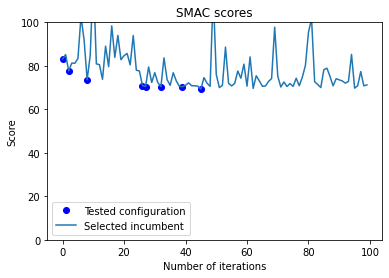

In [24]:
cfg_traj = [ traj.incumbent for traj in smac.trajectory]
plt.plot([smac.runhistory.get_cost(cfg) if cfg in cfg_traj else None for cfg in smac.runhistory.get_all_configs()], 'bo')
plt.plot([smac.runhistory.get_cost(cfg)  for cfg in  smac.runhistory.get_all_configs()])
plt.title('SMAC scores')
plt.legend(['Tested configuration', 'Selected incumbent'])
plt.xlabel('Number of iterations')
plt.ylim([0,100])
plt.ylabel('Score')
plt.show()

In [25]:
config={
  'batch_size': 1347,
  'epochs': 20,
  'ksize': 8,
  'n_channels': 87,
  'regressor_size': 609,
}

batch_size = config["batch_size"]
epochs = config["epochs"]
n_channels= config["n_channels"]
ksize = config["ksize"]
regressor_size= config["regressor_size"]

# Setup data
X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=8)
valid_loader = DataLoader(valid, batch_size=256)

from pytorch_lightning.callbacks import EarlyStopping

trainer = pl.Trainer(max_epochs=epochs,
                     accelerator="gpu",
                     max_time="00:01:00:00",
                     callbacks=[EarlyStopping("val_loss",
                                              verbose=True, 
                                              patience=3,
                                              mode="min")])

tcn=TCN(n_channels=n_channels,k_size=ksize,regressor_size=regressor_size)
trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
test = TensorDataset(X_test_gf, y_test)
test_loader = DataLoader(test, batch_size=256, num_workers=8)

trainer.test(tcn,test_loader)[0]["test_loss"]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 783   
1 | regressor | Sequential | 4.5 M 
-----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.874    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.312


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.982 >= min_delta = 0.0. New best score: 81.330


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.602 >= min_delta = 0.0. New best score: 78.728


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.497 >= min_delta = 0.0. New best score: 74.231


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.484 >= min_delta = 0.0. New best score: 71.747


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.209 >= min_delta = 0.0. New best score: 69.538


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.449 >= min_delta = 0.0. New best score: 68.090


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.930 >= min_delta = 0.0. New best score: 67.160


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.682 >= min_delta = 0.0. New best score: 66.478


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.701 >= min_delta = 0.0. New best score: 65.777


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.436 >= min_delta = 0.0. New best score: 64.341


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.721 >= min_delta = 0.0. New best score: 63.620


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            81.46092987060547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


81.46092987060547

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 28it [00:00, ?it/s]

 Val Loss: 0.5643773807957928


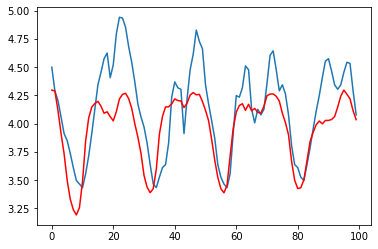

In [26]:
from sklearn.metrics import mean_squared_error

allp=np.array([])
for p in trainer.predict(tcn,test_loader):
    allp = np.concatenate([allp,p.reshape(-1)])
print(f' Val Loss: {np.sqrt(mean_squared_error(allp,y_test))}')
    
plt.plot(y_test.cpu()[-100:])
plt.plot(allp[-100:],c="red")
plt.show()